# Density vs Counts (2h window)

Loads `output/stability_timestep.csv` and `output/counts.csv`, computes 2-hour window averages per street aligned to each stability time step, saves a merged CSV, and plots counts vs mean density.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

stability_path = Path("../output/stability_timestep.csv")
counts_path = Path("../output/counts.csv")
output_path = Path("../output/counts_by_density.csv")

WINDOW_SECONDS = 7200  # 2 hours

In [2]:
stability = pd.read_csv(stability_path, sep=";")
counts = pd.read_csv(counts_path, sep=";")

counts = counts.sort_values("time_step").reset_index(drop=True)
street_cols = [c for c in counts.columns if c not in ("datetime", "time_step")]
print(f"Stability rows: {len(stability)}, count rows: {len(counts)}, streets: {len(street_cols)}")

Stability rows: 59, count rows: 2887, streets: 3475


In [3]:
rows = []
for _, row in stability.iterrows():
    t = row["time_step"]
    mask = (counts["time_step"] > t - WINDOW_SECONDS) & (counts["time_step"] <= t)
    window_df = counts.loc[mask, street_cols]
    if window_df.empty:
        avg = pd.Series({c: pd.NA for c in street_cols})
    else:
        avg = window_df.mean()
    out_row = {"time_step": t, "mean_density_vpk": row["mean_density_vpk"]}
    out_row.update(avg.to_dict())
    rows.append(out_row)

result = pd.DataFrame(rows)
result.to_csv(output_path, index=False)
result.head()

time_step  mean_density_vpk  8424  8423  8422      8421       8420  \
0       7500              1.49   0.0   0.0   0.0  0.166667  11.083333   
1      18000              2.09   0.0   0.0   0.0  0.125000  15.208333   
2      32400              2.83   0.0   0.0   0.0  0.208333  19.750000   
3      44100              3.55   0.0   0.0   0.0  0.416667  25.666667   
4      66300              4.31   0.0   0.0   0.0  0.458333  30.458333   

        8419       8418  8417  ...   17   16   14        13         9    6  \
0   6.958333  11.166667   0.0  ...  0.0  0.0  0.0  0.416667  1.416667  0.0   
1  10.166667  15.500000   0.0  ...  0.0  0.0  0.0  0.583333  2.958333  0.0   
2  13.625000  20.083333   0.0  ...  0.0  0.0  0.0  0.833333  2.833333  0.0   
3  17.583333  26.125000   0.0  ...  0.0  0.0  0.0  0.916667  4.000000  0.0   
4  19.333333  30.833333   0.0  ...  0.0  0.0  0.0  0.916667  3.791667  0.0   

          4         3         2         0  
0  0.208333  1.125000  0.208333  0.375000  
1  0.125000  2.833333  0.125000  0.583333  
2  0.375000  2.291667  0.375000  0.625000  
3  0.458333  3.583333  0.458333  1.000000  
4  1.208333  3.208333  1.208333  1.583333  

[5 rows x 3477 columns]

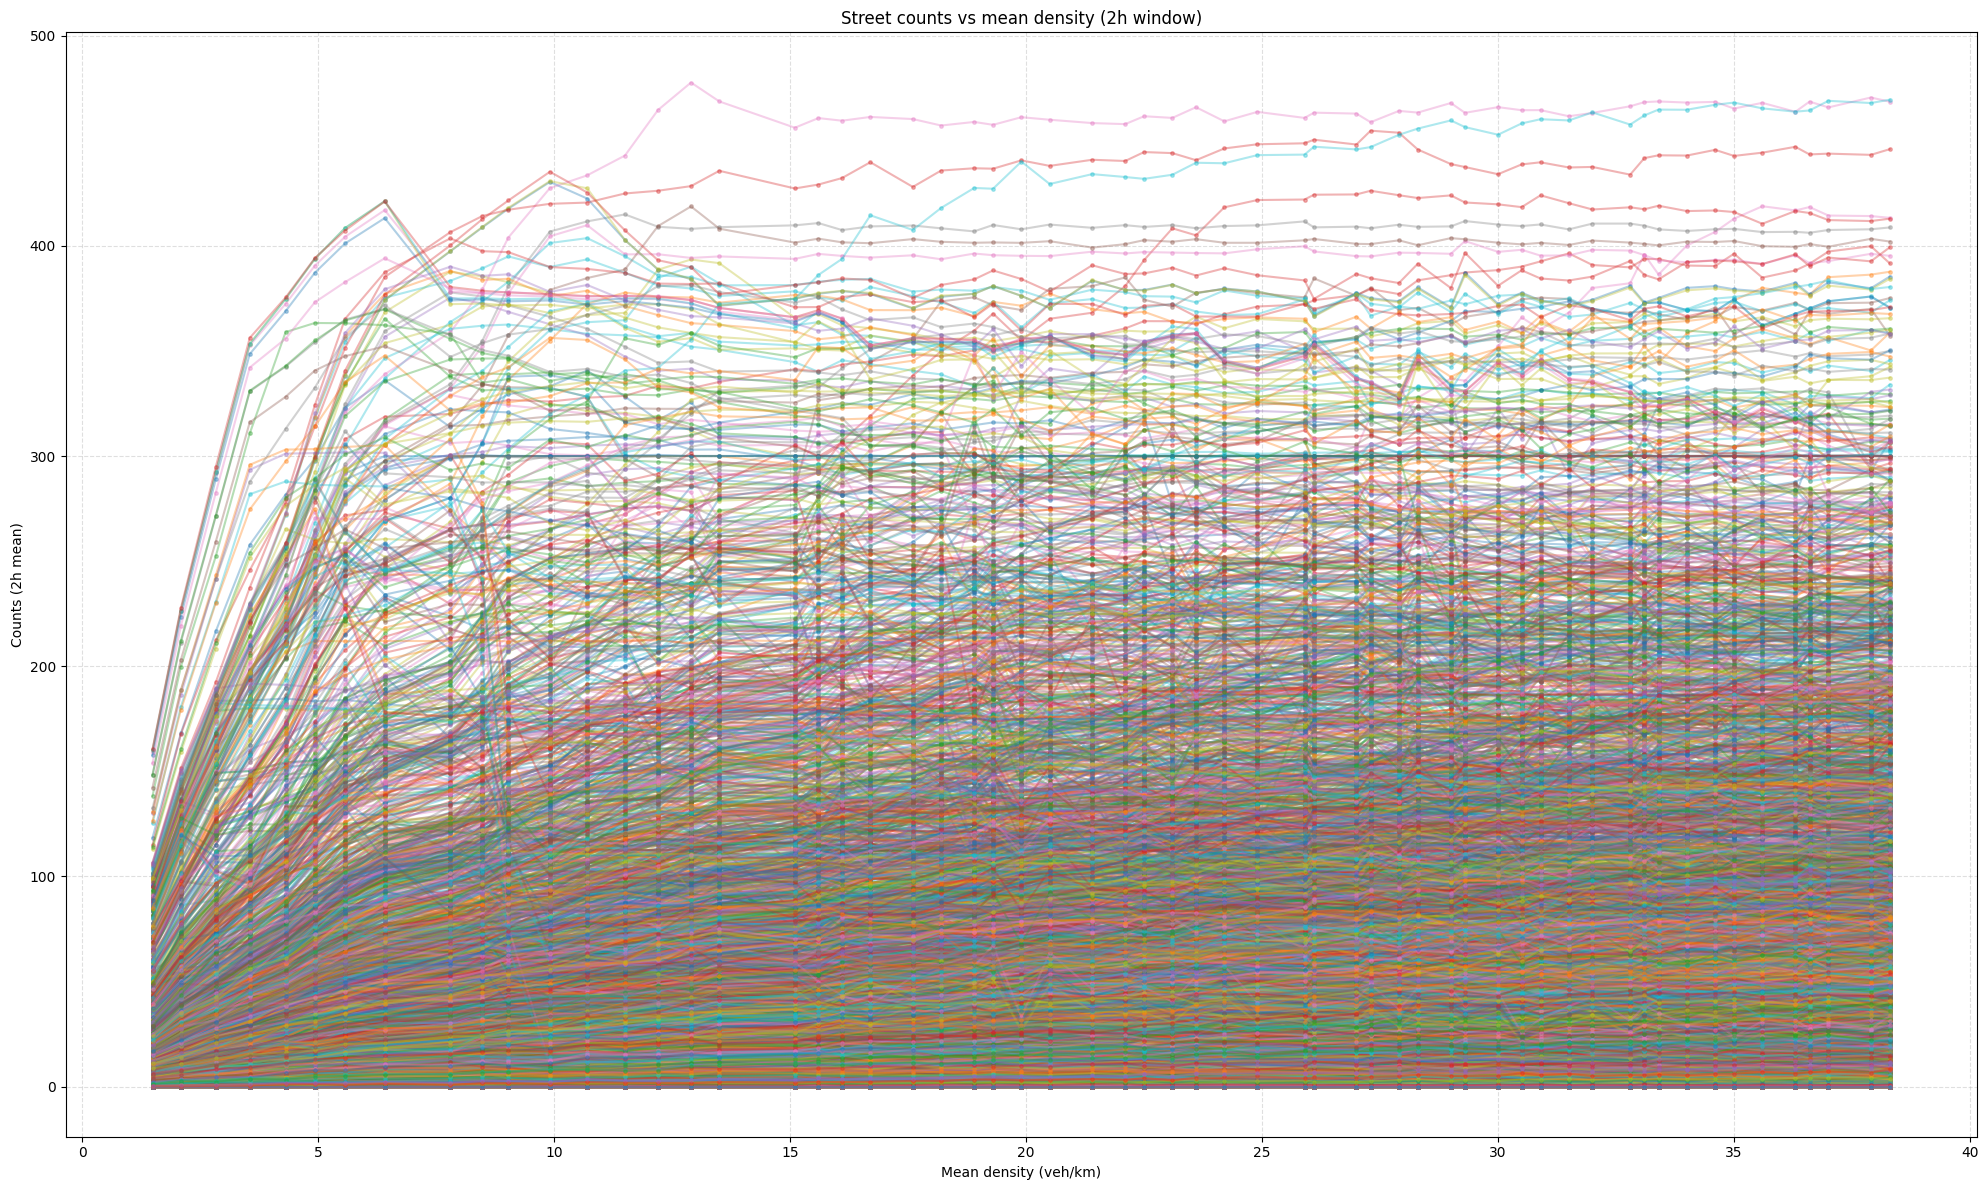

In [4]:
fig, ax = plt.subplots(figsize=(20, 12))
for col in street_cols:
    y = result[col]
    x = result["mean_density_vpk"]
    mask = y.notna() & x.notna()
    if mask.sum() < 2:
        continue
    ax.plot(x[mask], y[mask], marker="o", markersize=2.5, linewidth=1.5, alpha=0.35)

ax.set_xlabel("Mean density (veh/km)")
ax.set_ylabel("Counts (2h mean)")
ax.set_title("Street counts vs mean density (2h window)")
ax.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("../output/counts_vs_density.png", dpi=500)
plt.show()


In [5]:
# Identify streets with significant count drops (congestion heuristic) and re-plot
import numpy as np

DROP_RATIO_THRESHOLD = 0.2  # min/median <= 0.3 implies strong drop
MIN_SAMPLES =20

drop_streets = []
for col in street_cols:
    
    series = counts[col].dropna().iloc[8:]
    if len(series) < MIN_SAMPLES:
        continue
    med = series.median()
    if med <= 0:
        continue
    
    min_val = series.min()
    if (min_val / med) <= DROP_RATIO_THRESHOLD:
        drop_streets.append(col)

print(f"Congestion-suspect streets: {len(drop_streets)} / {len(street_cols)} (threshold={DROP_RATIO_THRESHOLD})")




Congestion-suspect streets: 2956 / 3475 (threshold=0.2)


In [6]:
# Refined congestion filter: strong drop + ever >=100 + had at least one decrease
import numpy as np

DROP_RATIO_THRESHOLD = 0.2
MIN_SAMPLES = 5
MIN_PEAK = 80
MAX_STEP = 30

refined_streets = []
for col in street_cols:
    series = counts[col].dropna()
    if len(series) < MIN_SAMPLES:
        continue
    first_steps = series.iloc[:MAX_STEP]
    if not (first_steps >= MIN_PEAK).any():  # never reached 100
        continue
    if not (series.diff().lt(0).any()):
        continue  # never decreased
    med = series.median()
    if med <= 0:
        continue
    if (series.min() / med) <= DROP_RATIO_THRESHOLD:
        refined_streets.append(col)

print(
    f"Refined congestion streets: {len(refined_streets)} / {len(street_cols)} "
    f"(drop<= {DROP_RATIO_THRESHOLD}, peak>= {MIN_PEAK}, had decrease)"
)

# fig, ax = plt.subplots(figsize=(20, 12))
# for col in refined_streets:
#     y = result[col]
#     x = result["mean_density_vpk"]
#     mask = y.notna() & x.notna()
#     if mask.sum() < 2:
#         continue
#     ax.plot(x[mask], y[mask], marker="o", markersize=3, linewidth=1.1, alpha=0.7)

# ax.set_xlabel("Mean density (veh/km)")
# ax.set_ylabel("Counts (2h mean)")
# ax.set_title("Counts vs mean density (refined congestion streets)")
# ax.grid(True, which="both", linestyle="--", alpha=0.4)
# plt.tight_layout()
# plt.savefig("../output/counts_vs_density_filtered.png", dpi=500)
# plt.show()

Refined congestion streets: 214 / 3475 (drop<= 0.2, peak>= 80, had decrease)


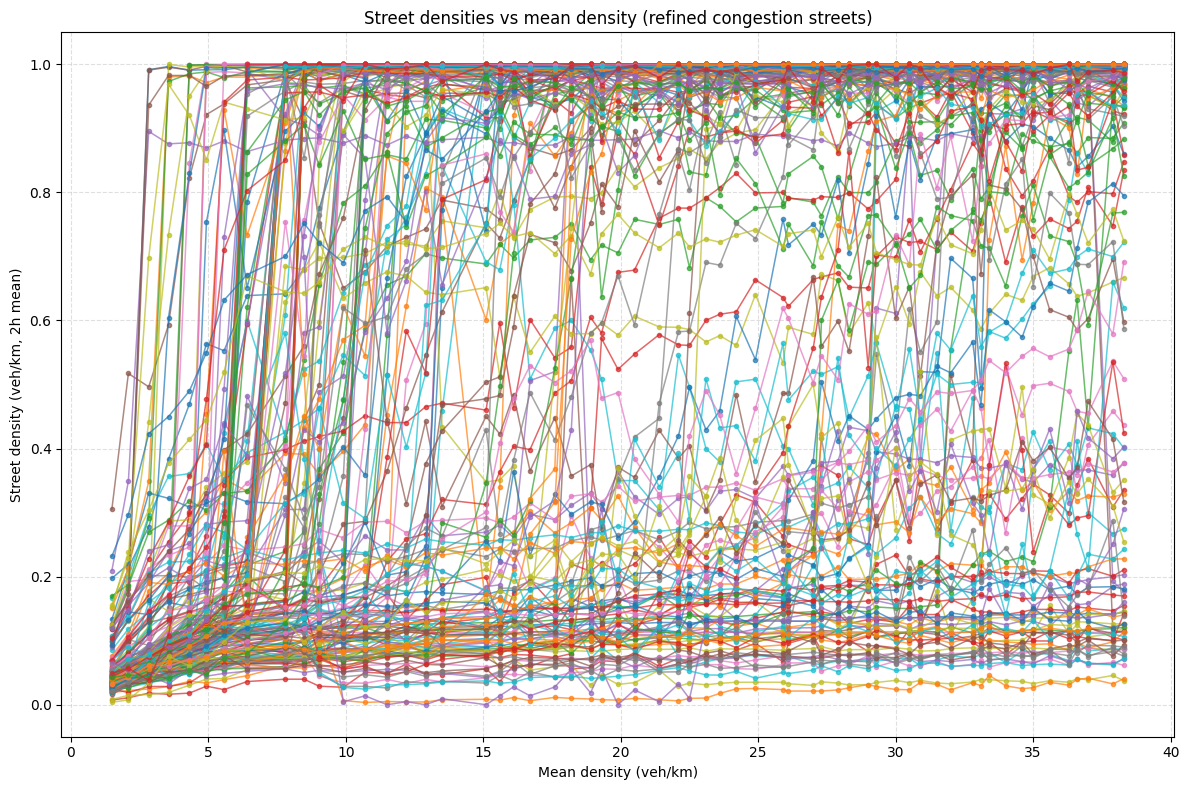

In [7]:
# Plot 2h-averaged street densities (refined congestion streets) vs mean density
import pandas as pd

if 'refined_streets' not in globals() or not refined_streets:
    print("refined_streets is empty or undefined; run the refined filter cell first.")
else:
    densities_path = Path("../output/densities.csv")
    dens = pd.read_csv(densities_path, sep=";")
    dens = dens.sort_values("time_step").reset_index(drop=True)
    dens_cols = [c for c in dens.columns if c not in ("datetime", "time_step")]
    target_cols = [c for c in refined_streets if c in dens_cols]

    dens_rows = []
    for _, row in stability.iterrows():
        t = row["time_step"]
        mask = (dens["time_step"] > t - WINDOW_SECONDS) & (dens["time_step"] <= t)
        window_df = dens.loc[mask, target_cols]
        if window_df.empty:
            avg = pd.Series({c: pd.NA for c in target_cols})
        else:
            avg = window_df.mean()
        out_row = {"time_step": t, "mean_density_vpk": row["mean_density_vpk"]}
        out_row.update(avg.to_dict())
        dens_rows.append(out_row)

    dens_result = pd.DataFrame(dens_rows)

    fig, ax = plt.subplots(figsize=(12, 8))
    for col in target_cols:
        y = dens_result[col]
        x = dens_result["mean_density_vpk"]
        mask = y.notna() & x.notna()
        if mask.sum() < 2:
            continue
        ax.plot(x[mask], y[mask], marker="o", markersize=3, linewidth=1.1, alpha=0.7)

    ax.set_xlabel("Mean density (veh/km)")
    ax.set_ylabel("Street density (veh/km, 2h mean)")
    ax.set_title("Street densities vs mean density (refined congestion streets)")
    ax.grid(True, which="both", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

Selected streets: 77 / 8425


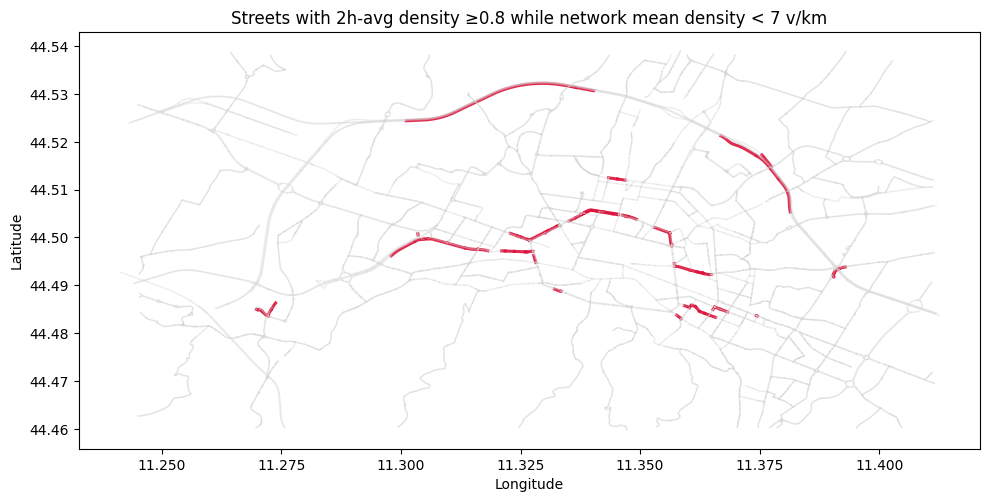

In [8]:
# Map streets that hit 2h-avg density >=0.8 while network mean density < 7 v/km (all streets in counts.csv)
import pandas as pd

stability = pd.read_csv(Path("../output/stability_timestep.csv"), sep=";")
dens = pd.read_csv(Path("../output/densities.csv"), sep=";")
counts = pd.read_csv(Path("../output/counts.csv"), sep=";")

street_cols = [c for c in counts.columns if c not in ("datetime", "time_step")]
dens_cols = [c for c in dens.columns if c not in ("datetime", "time_step")]
target_cols = [c for c in street_cols if c in dens_cols]

WINDOW_SECONDS = 7200  # 2h window
rows = []
for _, row in stability.iterrows():
    t = row["time_step"]
    mask = (dens["time_step"] > t - WINDOW_SECONDS) & (dens["time_step"] <= t)
    window_df = dens.loc[mask, target_cols]
    if window_df.empty:
        avg = pd.Series({c: pd.NA for c in target_cols})
    else:
        avg = window_df.mean()
    out_row = {"time_step": t, "mean_density_vpk": row["mean_density_vpk"]}
    out_row.update(avg.to_dict())
    rows.append(out_row)

dens_win = pd.DataFrame(rows)

selected = []
for col in target_cols:
    series = dens_win[col]
    mask = series.notna() & (dens_win['mean_density_vpk'] < 8) & (series >= 0.9)
    if mask.any():
        selected.append(col)

print(f"Selected streets: {len(selected)} / {len(dens_cols)}")

# Map drawing
edges = pd.read_csv(Path("../input/edges_tl.csv"), sep=';')
edges['id_str'] = edges['id'].astype(str)
geom_map = edges.set_index('id_str')['geometry'].to_dict()

import math
import matplotlib.pyplot as plt

def parse_linestring(wkt):
    if not isinstance(wkt, str) or 'LINESTRING' not in wkt:
        return None
    inner = wkt.split('(', 1)[1].rsplit(')', 1)[0]
    coords = []
    for pair in inner.split(','):
        parts = pair.strip().split()
        if len(parts) != 2:
            continue
        x, y = map(float, parts)
        coords.append((x, y))
    return coords if coords else None

fig, ax = plt.subplots(figsize=(10, 10))
# Highlight selected streets
for sid in selected:
    geom = geom_map.get(str(sid))
    coords = parse_linestring(geom)
    if not coords:
        continue
    xs, ys = zip(*coords)
    ax.plot(xs, ys, color='crimson', linewidth=2.2, alpha=0.9)
# Context: all target streets
for sid in target_cols:
    if sid in selected:
        continue
    geom = geom_map.get(str(sid))
    coords = parse_linestring(geom)
    if not coords:
        continue
    xs, ys = zip(*coords)
    ax.plot(xs, ys, color='lightgray', linewidth=1.0, alpha=0.4)

ax.set_title('Streets with 2h-avg density ≥0.8 while network mean density < 7 v/km')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

Streets kept after zero-speed+maxspeed filter: 7494 / 8425


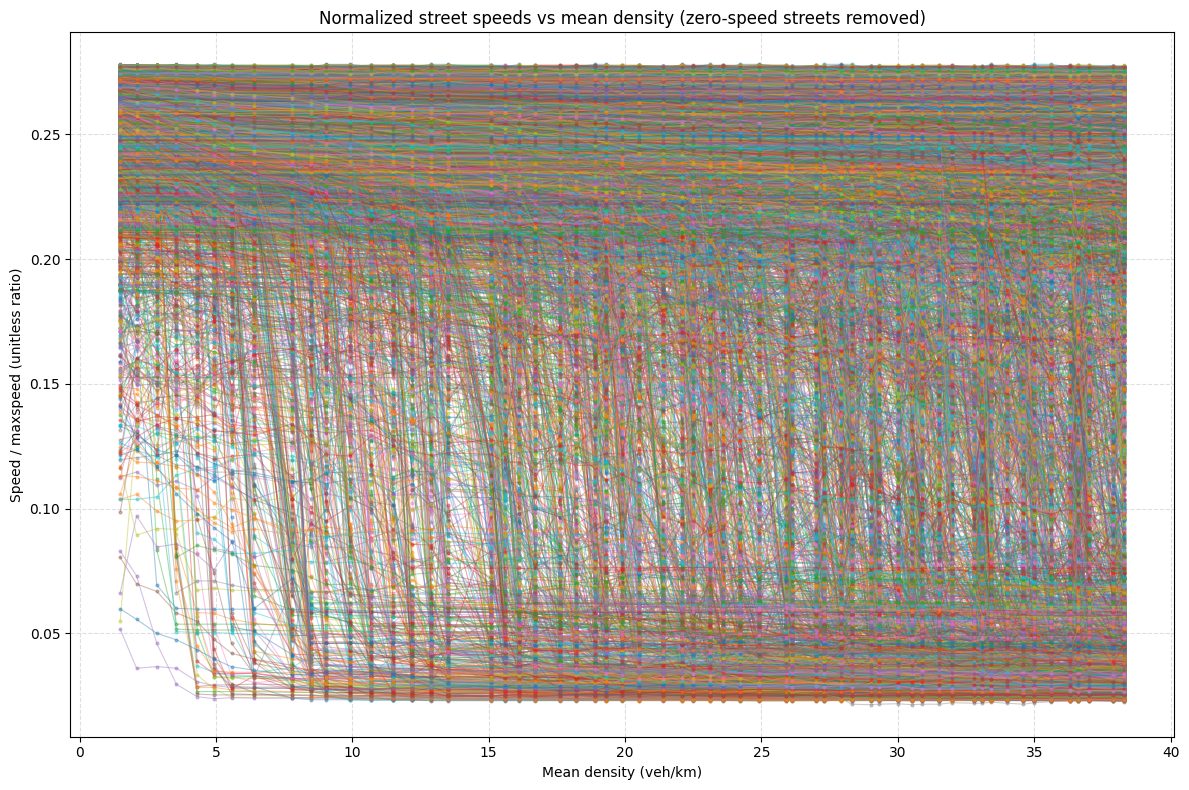

In [11]:
# Plot normalized street speeds vs mean density, dropping streets that hit 0 speed
import pandas as pd
import matplotlib.pyplot as plt

stability = pd.read_csv(Path("../output/stability_timestep.csv"), sep=";")
speeds = pd.read_csv(Path("../output/street_speeds.csv"), sep=";")
maxspeed_df = pd.read_csv(Path("../input/edges_tl.csv"), sep=";")

speeds = speeds.sort_values("time_step").reset_index(drop=True)
stability = stability.sort_values("time_step").reset_index(drop=True)

speed_cols = [c for c in speeds.columns if c not in ("datetime", "time_step")]
# Map street id -> maxspeed
maxspeed_map = maxspeed_df.set_index(maxspeed_df['id'].astype(str))['maxspeed'].to_dict()

# Drop streets with any zero speed or missing maxspeed
kept_cols = []
for col in speed_cols:
    ms = maxspeed_map.get(col)
    if ms is None or pd.isna(ms) or ms == 0:
        continue
    series = speeds[col]
    if (series == 0).any():
        continue
    kept_cols.append(col)

print(f"Streets kept after zero-speed+maxspeed filter: {len(kept_cols)} / {len(speed_cols)}")

merged = speeds.merge(
    stability[["time_step", "mean_density_vpk"]], on="time_step", how="inner"
)

fig, ax = plt.subplots(figsize=(12, 8))
for col in kept_cols:
    ms = maxspeed_map[col]
    y = merged[col] / ms  # normalized speed (ratio to maxspeed)
    x = merged["mean_density_vpk"]
    mask = y.notna() & x.notna()
    if mask.sum() < 2:
        continue
    ax.plot(x[mask], y[mask], marker="o", markersize=2, linewidth=0.8, alpha=0.4)

ax.set_xlabel("Mean density (veh/km)")
ax.set_ylabel("Speed / maxspeed (unitless ratio)")

ax.set_title("Normalized street speeds vs mean density (zero-speed streets removed)")
ax.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()